# Conservative MKCVA-MPC for Evaporator

In [2]:
# Libraries for Pyomo (for simulation only)
from pyomo.environ import *
from pyomo.dae import DerivativeVar, ContinuousSet

# Libraries for MKCVA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
from scipy.linalg import cholesky
import matplotlib.pyplot as plt
import statsmodels.api as sm
from time import time
import pandas as pd
import numpy as np
import cyipopt
import pickle
import json

## Declare classes for MKCVA

In [3]:
class KPCA:
    def kernel_func(self, x1, x2):
        # x1 size: [no. of samples x no. of features]
        # x2 size: [no. of samples x no. of features]
        
        D = np.sum((x1 / self.kw) ** 2, axis=1, keepdims=True) \
            + np.sum((x2 / self.kw).T ** 2, axis=0, keepdims=True) \
            - 2 * np.tensordot(x1 / self.kw**2, x2.T, axes=1)
        L = np.tensordot(x1, x2.T, axes=1) + 1
        return self.w * L + (1 - self.w) * np.exp(-D)
        
    def fit_transform(self, X, kw, w, n_comp=None):
        # Compute kernel matrix
        self.X = X
        self.kw = kw
        self.w = w
        self.N = len(self.X)
        
        # Calculate reduced kernel matrix with k-medoids clustering 
        dist = pairwise_distances(self.X)
        dm = kmedoids.KMedoids(method='fasterpam', 
                               n_clusters=int(0.2*self.N), 
                               random_state=0).fit(dist)
        self.X_red = X[dm.medoid_indices_, :]
        self.N_red = len(dm.medoid_indices_)
        self.medoid_indices = dm.medoid_indices_
        self.K = self.kernel_func(self.X_red, self.X_red)

        # Center the kernel matrix
        self.U = np.ones((self.N_red, self.N_red)) / self.N_red
        Kc = self.K - self.U @ self.K - self.K @ self.U + self.U @ self.K @ self.U

        # Perform eigenvalue decomposition
        eigvals, eigvecs = np.linalg.eigh(Kc / self.N_red)

        # Ensure the eigenvalues are sorted in decreasing order
        ind = (-eigvals).argsort()
        eigvals = eigvals[ind]
        eigvecs = eigvecs[:,ind]
        
        if n_comp == None:
            # Get eigenvalues using CPV = 99%
            CPV = np.cumsum(eigvals) / np.sum(eigvals)
            self.n_comp = np.argwhere(CPV > 0.99)[0][0]
        else:
            self.n_comp = n_comp
        
        self.CPV = CPV
        
        # Compute the projection matrix
        self.P = eigvecs[:,:self.n_comp] @ np.diag(eigvals[:self.n_comp] ** -0.5)
        
        # Project the training data X via the reduced centered kernel matrix
        scores = self.transform(self.X)
        return scores
    
    def transform(self, Xt):
        if len(Xt.shape) == 1:
            Xt = Xt.reshape(1, -1)
        
        Kt = np.transpose(self.kernel_func(self.X_red, Xt))
        Ut = np.ones((Xt.shape[0], self.N_red)) / self.N_red
        Kct = Kt - Ut @ self.K - Kt @ self.U + Ut @ self.K @ self.U
        scores = Kct @ self.P
        return scores
    
class MKCVA:
    def __init__(self, verbose=None):
        if verbose == None:
            self.verbose = 0
        else:
            self.verbose = verbose
    
    def identify(self, Z_train, UI, YI, kw=None, w=None, n_states=None):
        
        start = time()
        self.UI = UI  # Column indices of input vars 
        self.YI = YI  # Column indices of output vars
        N = Z_train.shape[0]

        # Perform Standard Scaling on raw data [u y]
        sc_raw = StandardScaler()
        Z_train_sc = sc_raw.fit_transform(Z_train)
        y_train = Z_train_sc[:, YI]
        self.sc_raw = sc_raw

        # Perform KPCA on scaled [u(k), y(k-1)] data
        
        Z_kpca = np.hstack((Z_train_sc[1:, self.UI], 
                            Z_train_sc[:-1, self.YI]))
        
        kpca_uy = KPCA()
        kpca_score_uy = kpca_uy.fit_transform(Z_kpca, kw, w)
        self.kpca_uy = kpca_uy
        
        # Perform KPCA on scaled [y] data
        kpca_y = KPCA()
        kw = kpca_uy.kw * (len(YI) / Z_train.shape[1])
        kpca_score_y = kpca_y.fit_transform(Z_train_sc[:,YI], kw[YI], w)
        N_uy, N_y = kpca_uy.n_comp, kpca_y.n_comp

        # Calculate the suggested no. of lags on the KPCA scores
        _, ci = sm.tsa.acf(np.sum(kpca_score_y ** 2, axis=1), alpha=0.05)
        self.n_lags = np.argwhere(ci[:,0] < 0)[0][0]
        p = f = self.n_lags
        
        # Create Hankel matrices: Yp and Yf from KPCA scores
        Yp, Yf, Yp_all = [], [], []
        for k in np.arange(N-p-f):
            Yp.append(np.flip(kpca_score_uy[k:k+p, :].reshape(-1, 1)))

        for k in np.arange(1, N-p-f+1):
            Yf.append(kpca_score_y[k+p:k+p+f, :].reshape(-1, 1))

        Yp = np.transpose(np.hstack(Yp))
        Yf = np.transpose(np.hstack(Yf))
        Np = Yp.shape[0]

        # Standardize the Hankel matrices
        sc_p = StandardScaler()
        sc_f = StandardScaler()
        Yp_scaled = sc_p.fit_transform(Yp)
        Yf_scaled = sc_f.fit_transform(Yf)
        self.sc_p = sc_p

        # Perform CCA
        Epp = cholesky(np.dot(Yp_scaled.T, Yp_scaled))  # Past Cholesky matrix
        Eff = cholesky(np.dot(Yf_scaled.T, Yf_scaled))  # Future Cholesky matrix
        Efp = np.dot(Yf_scaled.T, Yp_scaled)            # Cross-covariance matrix
        H = np.linalg.inv(Eff.T) @ Efp @ np.linalg.inv(Epp)

        U, S, V = np.linalg.svd(H)

        # Calculate the suggested no. of states via knee of SV plot
        if n_states == None:
            n_states = np.minimum(2 + np.argmax(np.diff(np.diff(S))), 10)
        self.n_states = n_states

        if self.verbose:
            print(f'No. of KPCs on [u y]: {N_uy}')
            print(f'No. of KPCs on [y]:   {N_y}')
            print(f'No. of lags: {self.n_lags}')
            plt.figure(figsize=(12, 3))
            plt.subplot(131)
            plt.title('CPV Plot for KPCA on [u y]')
            plt.plot(np.arange(len(kpca_uy.CPV))+1, kpca_uy.CPV, 'b.--')
            plt.scatter(kpca_uy.n_comp, kpca_uy.CPV[kpca_uy.n_comp-1], c='r')
            plt.xlim([0, 30])
            plt.grid()
            plt.subplot(132)
            plt.title('CPV Plot for KPCA on [y]')
            plt.plot(np.arange(len(kpca_y.CPV))+1, kpca_y.CPV, 'b.--')
            plt.scatter(kpca_y.n_comp, kpca_y.CPV[kpca_y.n_comp-1], c='r')
            plt.xlim([0, 30])
            plt.grid()
            plt.subplot(133)
            plt.plot(np.arange(15)+1, S[:15], 'b.--')
            plt.scatter(n_states, S[n_states-1], c='r')
            plt.title('Singular Values plot')
            print(f'No. of states: {n_states}')
            plt.grid()
            plt.tight_layout()
            plt.show()

        # Calculate the state vectors, X
        Vn = np.transpose(V[:n_states, :])
        Jn = np.dot(Vn.T, np.linalg.inv(Epp.T))
        X = Jn @ Yp_scaled.T
        self.Jn = Jn
        
        # Solve for A, B, C, D, K
        M = X.shape[1]
        tk = np.transpose(kpca_score_uy[p-1:p+M-1, :])
        yk = np.transpose(y_train[p:p+M, :])

        CD = yk[:,:(M-1)] @ np.linalg.pinv(np.vstack((X[:,:(M-1)], 
                                                      tk[:,:(M-1)])))
        C = CD[:len(YI), :n_states]          # Output matrix
        D = CD[:len(YI), n_states:]          # Feedthrough matrix

        E = yk[:,:(M-1)] - C @ X[:,:(M-1)] - D @ tk[:,:(M-1)]
        ABK = X[:,1:M] @ np.linalg.pinv(np.vstack((X[:,:(M-1)], 
                                                   tk[:,:(M-1)], E)))
        A = ABK[:,:n_states]                 # State transition matrix
        B = ABK[:,n_states:(n_states+N_uy)]  # Input matrix
        K = ABK[:,(n_states+N_uy):]          # Kalman gain
        
        self.ident_time = time() - start     # Time elapsed for identification
        
        self.A, self.B, self.C, self.D, self.K = A, B, C, D, K
        self.X = X
       
    def init_sim(self, Z_test_sc):
        # Calculate initial state x(0) using CVA projection matrix
        tk = self.kpca_uy.transform(Z_test_sc)
        tk_p = np.flip(tk[:self.n_lags, :].reshape(1, -1))
        Yp_scaled = self.sc_p.transform(tk_p)
        x0 = self.Jn @ Yp_scaled.T
        t0 = tk[self.n_lags, :].reshape(-1, 1)
        return x0, t0
    
    def simulate(self, Z_test):
        start = time()
        Nt = Z_test.shape[0]
        Z_test_sc = self.sc_raw.transform(Z_test)
        x_pred = np.zeros((self.n_states, Nt - self.n_lags + 1)) 
        y_pred = np.zeros((len(self.YI), Nt - self.n_lags + 1))
        x0, t0 = self.init_sim(Z_test_sc)
        y0 = self.C @ x0 + self.D @ t0
        x_pred[:, 0] = x0.ravel()
        y_pred[:, 0] = y0.ravel()
        exit_code = 0
        
        for j in np.arange(1, y_pred.shape[1]):
            zk = np.hstack((Z_test_sc[j+self.n_lags-1, self.UI], 
                            y_pred[:, j-1]))
            tk = self.kpca_uy.transform(zk.reshape(1, -1))
            xk_1 = x_pred[:, j-1].reshape(-1, 1)
            xk = self.A @ xk_1 + self.B @ tk.T
            yk = self.C @ xk + self.D @ tk.T
            x_pred[:, j] = xk.ravel()
            y_pred[:, j] = yk.ravel()
            if (np.abs(yk) > 1e3).any():
                exit_code = -1
        
        x_pred = np.transpose(x_pred)
        y_pred = np.transpose(y_pred)
        y_pred = (y_pred * self.sc_raw.scale_[self.YI]) + \
                           self.sc_raw.mean_[self.YI]
        self.sim_time = time() - start
        
        return x_pred, y_pred, exit_code
    
    def R2_score(self, Z_test, y_pred):
        r2 = np.zeros(len(self.YI))
        for k in range(len(self.YI)):
            y_true = Z_test[self.n_lags-1:, self.YI[k]]
            r2[k] = 1 - np.sum((y_true - y_pred[:, k]) ** 2) \
                    / np.sum((y_true - np.mean(y_true)) ** 2)   
        return r2
    
    def display(self):
        print(f'No. of medoids: {self.kpca_uy.N_red}')
        print(f'No. of KPCs on [u y]: {self.kpca_uy.n_comp}')
        print(f'No. of lags: {self.n_lags}')
        print(f'No. of states: {self.n_states}')
        print(f'Indices of u: {self.UI}')
        print(f'Indices of y: {self.YI}')
        print('State-space matrices:')
        print(self.A)
        print(self.B)
        print(self.C)
        print(self.D)
        print(self.K)

## Pyomo simulation of First-principles DAE

In [4]:
def solve_model(ti, tf, F200data, P100data, F3data, N_hor, init_data):

    evap = ConcreteModel()

    evap.ti = Param(initialize=ti)
    evap.tf = Param(initialize=tf)
    evap.t = ContinuousSet(bounds=(evap.ti,evap.tf))

    # States
    evap.L2 = Var(evap.t, initialize=1, bounds=(0, 4))
    evap.P2 = Var(evap.t, initialize=50.5)
    evap.X2 = Var(evap.t, initialize=25)

    # Manipulated variable to control L2 via P-control
    evap.F2 = Var(evap.t, initialize=2)
    
    # Inputs and Disturbances
    evap.T200 = Param(evap.t, default=25)
    evap.F1 = Param(evap.t, default=10)
    evap.X1 = Param(evap.t, default=5)
    evap.T1 = Param(evap.t, default=40)

    evap.F200 = Param(evap.t, mutable=True)  # Input to be manipulated
    evap.P100 = Param(evap.t, mutable=True)  # Input to be manipulated
    evap.F3 = Param(evap.t, mutable=True)    # Input to be manipulated

    # Other outputs
    evap.F4 = Var(evap.t, initialize=8)
    evap.F5 = Var(evap.t, initialize=8)
    evap.T2 = Var(evap.t, initialize=84.6)
    evap.T3 = Var(evap.t, initialize=80.6)
    evap.F100 = Var(evap.t, initialize=9.27)
    evap.T100 = Var(evap.t, initialize=119.9)
    evap.Q100 = Var(evap.t, initialize=339.2)
    evap.T201 = Var(evap.t, initialize=46.15)
    evap.Q200 = Var(evap.t, initialize=308)

    # Setup derivative vars for states
    evap.dL2dt = DerivativeVar(evap.L2, initialize=init_data['dL2dt'])
    evap.dP2dt = DerivativeVar(evap.P2, initialize=init_data['dP2dt'])
    evap.dX2dt = DerivativeVar(evap.X2, initialize=init_data['dX2dt'])

    # Set an objective
    evap.obj = Objective(expr=1)

    evap.z1dot = Constraint(evap.t, rule = lambda m, i: \
                           m.dL2dt[i]*20 == m.F1[i] - m.F4[i] - m.F2[i])
    evap.z2dot = Constraint(evap.t, rule = lambda m, i: \
                           m.dX2dt[i]*20 == m.F1[i]*m.X1[i] - m.F2[i]*m.X2[i])
    evap.z3dot = Constraint(evap.t, rule = lambda m, i: \
                           m.dP2dt[i]*4 == m.F4[i] - m.F5[i])

    # Other constraints
    evap.con1 = Constraint(evap.t, rule = lambda m, i: \
                          m.T2[i] == 0.5616*m.P2[i] + 0.3126*m.X2[i] + 48.43)
    evap.con2 = Constraint(evap.t, rule = lambda m, i: \
                          m.T3[i] == 0.507*m.P2[i] + 55)
    evap.con3 = Constraint(evap.t, rule = lambda m, i: \
                          m.F4[i]*38.5 == m.Q100[i] - 0.07*m.F1[i]*(m.T2[i] - m.T1[i]))
    evap.con4 = Constraint(evap.t, rule = lambda m, i: \
                          m.T100[i] == 0.1538*m.P100[i] + 90)
    evap.con5 = Constraint(evap.t, rule = lambda m, i: \
                          m.Q100[i] == 0.16*(m.F1[i] + m.F3[i])*(m.T100[i] - m.T2[i]))
    evap.con6 = Constraint(evap.t, rule = lambda m, i: \
                          m.F100[i]*36.6 == m.Q100[i])
    evap.con7 = Constraint(evap.t, rule = lambda m, i: \
                          m.Q200[i]*(0.14*m.F200[i]+6.84) == 0.9576*m.F200[i]*(m.T3[i]-m.T200[i]))
    evap.con8 = Constraint(evap.t, rule = lambda m, i:\
                          m.T201[i] == m.T200[i] + m.Q200[i]/0.07/m.F200[i])
    evap.con9 = Constraint(evap.t, rule = lambda m, i: \
                          m.F5[i]*38.5 == m.Q200[i])

    def _init(m):
        yield m.L2[evap.ti] == init_data['L2']
        yield m.P2[evap.ti] == init_data['P2']
        yield m.X2[evap.ti] == init_data['X2']
    
    evap.initcon = ConstraintList(rule=_init)

    # Discretize using collocation
    discretizer = TransformationFactory('dae.collocation')
    discretizer.apply_to(evap, nfe=N_hor, ncp=3, scheme='LAGRANGE-RADAU')

    # P-controller
    def _p_control(m, i):
        if i > m.ti:
            return m.F2[i] == 2 + 5*(m.L2[m.t.prev(i)] - 1.0)
        else:
            return m.F2[i] == init_data['F2']

    evap.p_control = Constraint(evap.t, rule=_p_control)
    
    # Step change data
    timepoints = list(evap.t)
    i_data = np.arange(ti, tf)
        
    for i, t in enumerate(timepoints):
        pos = np.argwhere(t>=i_data)[-1]
        evap.F200[t] = F200data[pos][0]
        evap.P100[t] = P100data[pos][0]
        evap.F3[t] = F3data[pos][0]

    # Solve using Pyomo IPOPT
    solver = SolverFactory('cyipopt')
    res = solver.solve(evap)
    
    model_vars = evap.component_map(ctype=Var)
    model_params = evap.component_map(ctype=Param)

    s_list = []
    col_list = []
    ctr = 1
    for k in model_vars.keys():
        v = model_vars[k]
        if v.name == 'L2' or v.name == 'P2' or v.name == 'X2'\
           or v.name[0] == 'd' or v.name == 'F2':
            s = pd.Series(v.extract_values(), 
                          index=v.extract_values().keys())
            s.sort_index(inplace=True)
            s_list.append(s)
            col_list.append(v.name)
            ctr += 1

    for k in model_params.keys():
        v = model_params[k]
        if v.name == 'F200' or v.name == 'P100' or v.name == 'F3':
            s = pd.Series(v.extract_values(), 
                          index=v.extract_values().keys())
            s.sort_index(inplace=True)
            s_list.append(s)
            col_list.append(v.name)
            ctr += 1

    evap_df = pd.concat(s_list, axis=1)
    evap_df.columns = col_list
    return evap_df, res

## Load the Identified MKCVA Model

In [5]:
sys = pickle.load(open('evap_mkcva_sys3.pkl','rb'))

sys.display()

No. of medoids: 200
No. of KPCs on [u y]: 6
No. of lags: 15
No. of states: 6
Indices of u: [0 1 2]
Indices of y: [3 4 5]
State-space matrices:
[[ 9.35208931e-01  6.16237139e-04  5.54198993e-02  1.19359046e-02
  -1.27942514e-02 -3.48459307e-03]
 [ 2.03328165e-01  9.11826772e-01 -9.30992935e-02 -6.88971124e-03
  -2.64146368e-03  3.42975531e-03]
 [-5.02485718e-01  4.06403474e-01  6.96160721e-01  1.86576682e-03
  -1.17757873e-03  1.48231365e-02]
 [-7.16253802e-01  3.07691234e-01  2.82574906e-01  1.02124835e+00
  -2.31149005e-01  1.51693068e-02]
 [-2.88811811e-01  2.74154724e-01 -8.29277529e-03  1.19953670e-01
   8.06682262e-01  8.16864693e-02]
 [ 6.10103352e-01 -1.23377840e-02 -3.96841187e-01  8.66128520e-02
  -7.72888666e-02  8.52100588e-01]]
[[ 1.30819424e-04  5.10856478e-05  1.95490395e-05 -9.19309897e-05
   2.76239118e-05 -1.28927872e-04]
 [-2.97224024e-04  1.87805158e-05  1.32241735e-04 -5.90612712e-05
   1.58572508e-04  3.60327314e-04]
 [ 9.60269086e-04  5.94067277e-04  3.61131139e-0

## Declare class for MPC

In [6]:
def sim_mpc(sys, x0, y0, u):
    # Shape of x0: [n_states x 1]
    # Shape of y0: [n_y x 1] (not scaled)
    # Shape of u:  [n_u x N_hor] (not scaled)
    
    # u includes the initial state u0

    N = u.shape[1] # This is N_hor
    x_pred = np.zeros((sys.n_states, N+1))
    y_pred = np.zeros((len(sys.YI), N+1))
    x_pred[:, 0] = x0.ravel()
    y_pred[:, 0] = y0.ravel()

    for j in np.arange(1, N+1):
        zk = np.hstack((u[:, np.minimum(j, N-1)], 
                        y_pred[:, j-1]))
        zk = sys.sc_raw.transform(zk.reshape(1, -1))
        tk = sys.kpca_uy.transform(zk.reshape(1, -1))
        xk_1 = x_pred[:, j-1].reshape(-1, 1)
        xk = sys.A @ xk_1 + sys.B @ tk.T
        yk = sys.C @ xk + sys.D @ tk.T
        yk = (yk.ravel() * sys.sc_raw.scale_[sys.YI]) + \
                           sys.sc_raw.mean_[sys.YI]
        x_pred[:, j] = xk.ravel()
        y_pred[:, j] = yk.ravel()

    x_pred = np.transpose(x_pred)
    y_pred = np.transpose(y_pred)

    return x_pred, y_pred

class NLP_MPC:
    def __init__(self, x0, y0, u0, X2_sp):
        self.x0 = x0
        self.y0 = y0
        self.u0 = u0
        self.X2_sp = X2_sp

    def objective(self, v):
        
        u_ = (v.reshape(-1, 3)-0.5) * np.array([100, 100, 20]) + \
                                      np.array([208, 194.7, 50])   # nominal condition
        u = np.vstack((u0.reshape(1, -1), u_))
        
        x, y = sim_mpc(sys, x0, y0, np.transpose(u))
        
        # Objective function
        return np.sum(((y[:, 2] - self.X2_sp)/25) ** 2) + \
               0.8*np.sum((np.diff(u, axis=0) / np.array([100, 100, 20]))**2)
    
    def gradient(self, v):
        g = np.zeros(v.shape)
        step = 1e-3
        for j in range(nvar):
            x_hi = v.copy()
            x_lo = v.copy()
            x_hi[j] = x_hi[j] + step
            x_lo[j] = x_lo[j] - step
            g[j] = (self.objective(x_hi) - self.objective(x_lo)) / (2*step)
        
        return g
    
    #def intermediate(self, alg_mod, iter_count, obj_value, inf_pr, inf_du, mu,
    #                 d_norm, regularization_size, alpha_du, alpha_pr,
    #                 ls_trials):
    #    """Prints information at every Ipopt iteration."""
    #
    #    msg = "Objective value at iteration #{:d} is - {:g}"
    #
    #    print(msg.format(iter_count, obj_value))

## Run the MPC

Horizon: 0 min to 10 min
IPOPT took 4.73 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Please recompile / update your pynumero_ASL library.
Pyomo Status: ok


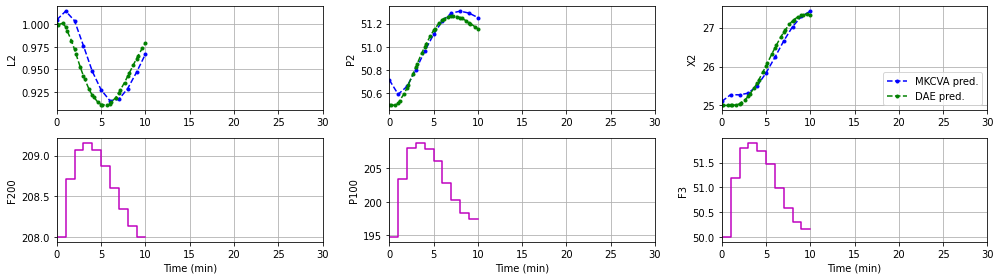

Horizon: 1 min to 11 min
IPOPT took 5.60 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


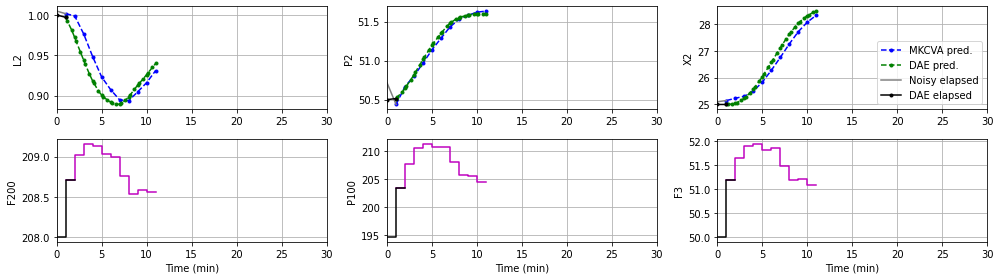

Horizon: 2 min to 12 min
IPOPT took 2.93 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


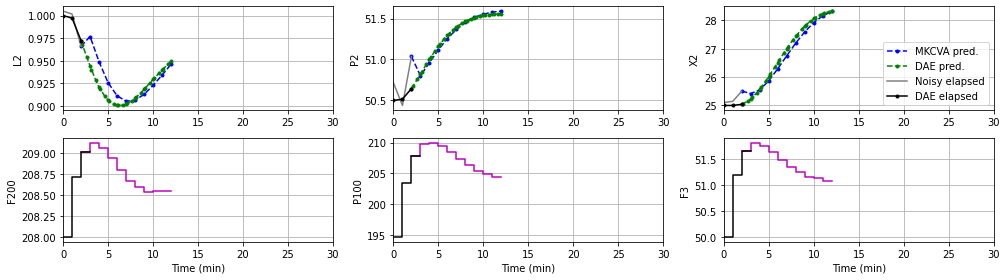

Horizon: 3 min to 13 min
IPOPT took 4.90 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


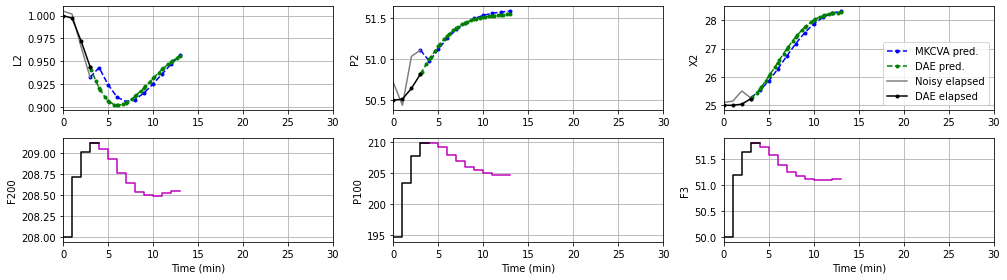

Horizon: 4 min to 14 min
IPOPT took 3.59 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


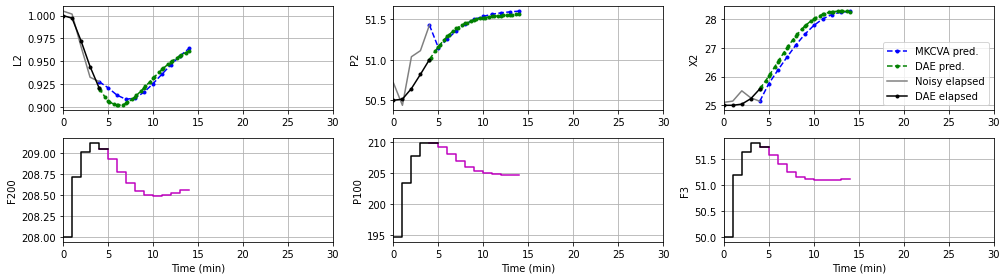

Horizon: 5 min to 15 min
IPOPT took 2.17 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


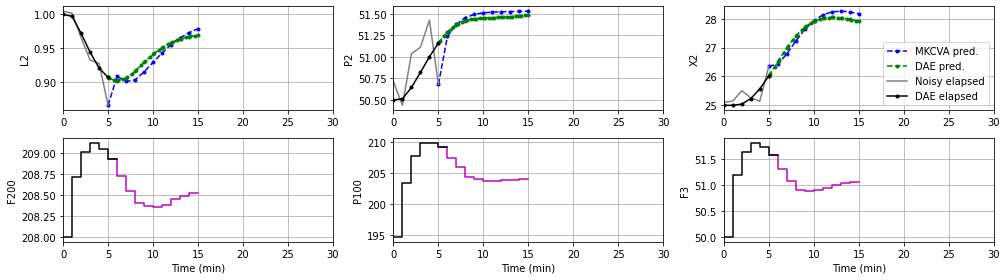

Horizon: 6 min to 16 min
IPOPT took 4.79 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


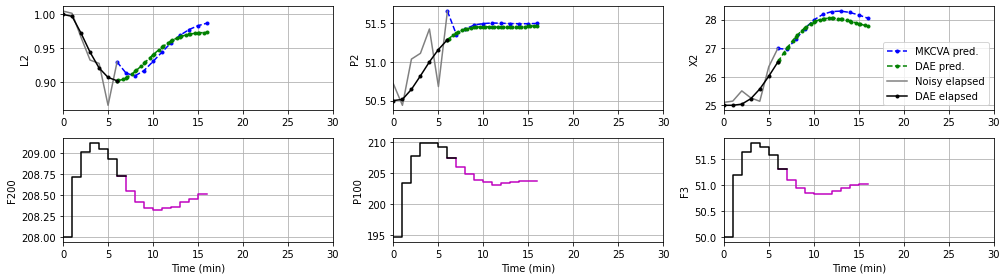

Horizon: 7 min to 17 min
IPOPT took 3.93 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


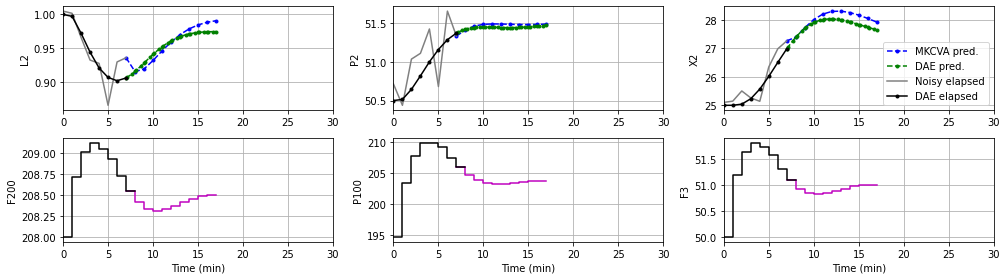

Horizon: 8 min to 18 min
IPOPT took 2.39 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


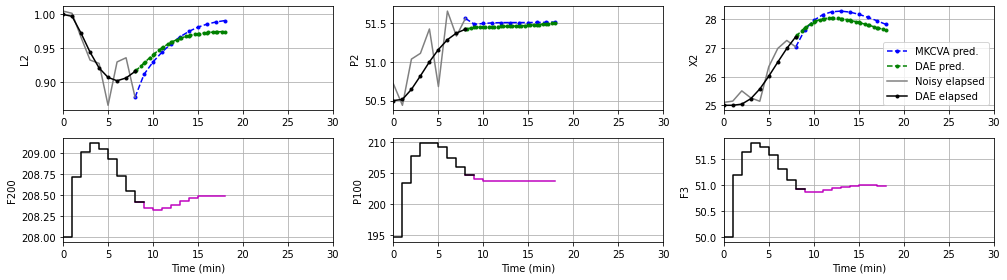

Horizon: 9 min to 19 min
IPOPT took 4.88 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


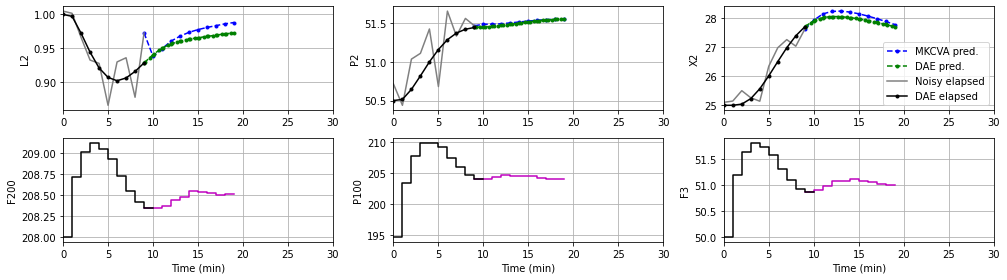

Horizon: 10 min to 20 min
IPOPT took 3.79 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


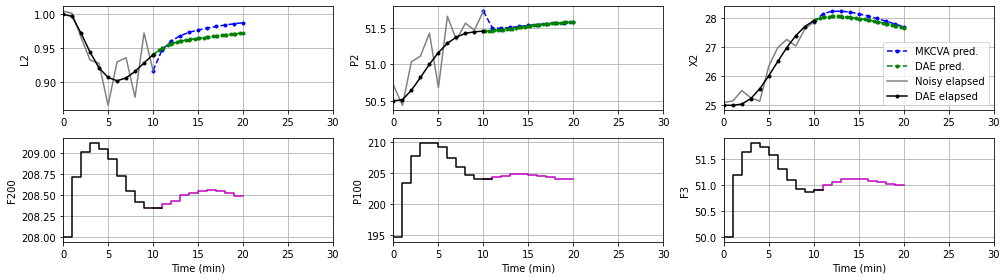

Horizon: 11 min to 21 min
IPOPT took 2.83 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


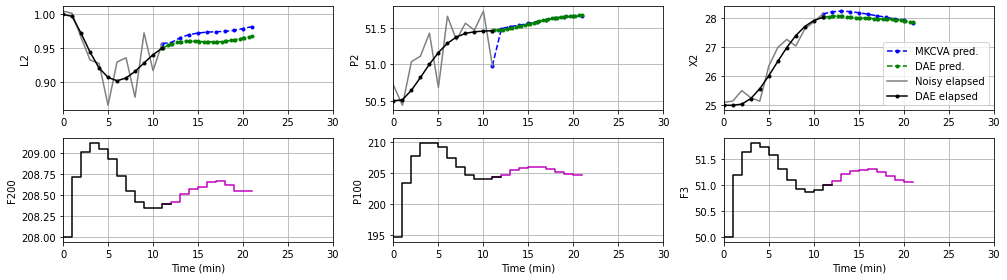

Horizon: 12 min to 22 min
IPOPT took 4.72 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


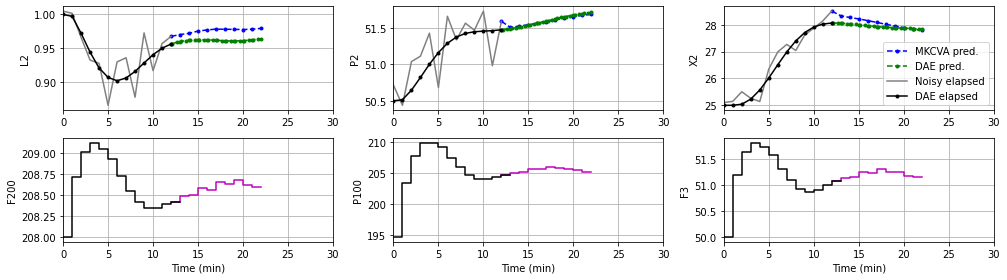

Horizon: 13 min to 23 min
IPOPT took 4.41 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


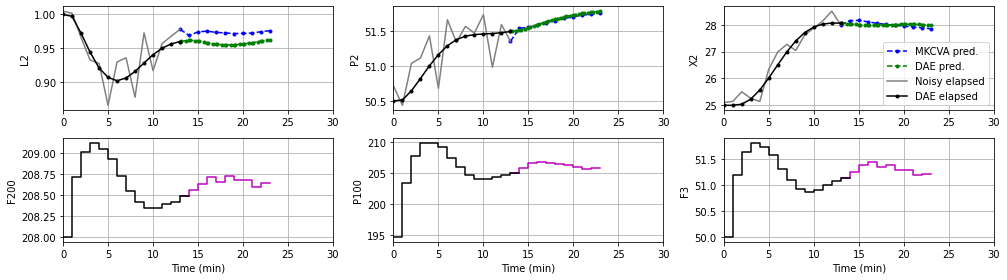

Horizon: 14 min to 24 min
IPOPT took 3.85 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


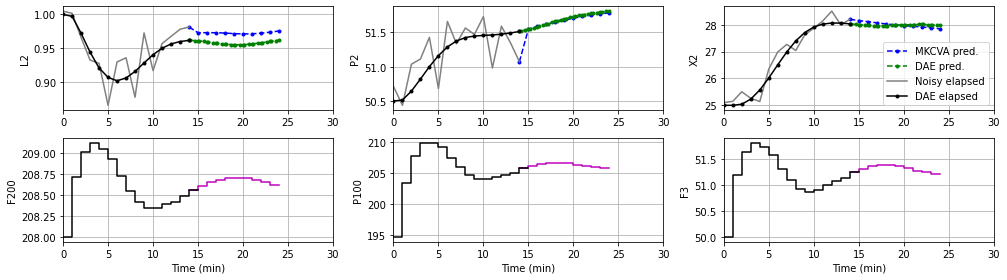

Horizon: 15 min to 25 min
IPOPT took 4.73 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


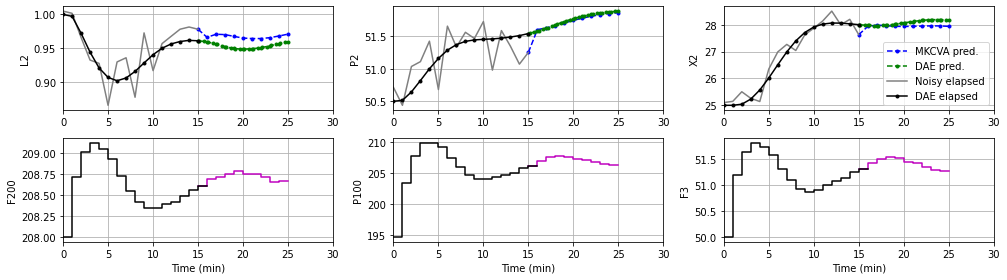

Horizon: 16 min to 26 min
IPOPT took 3.34 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


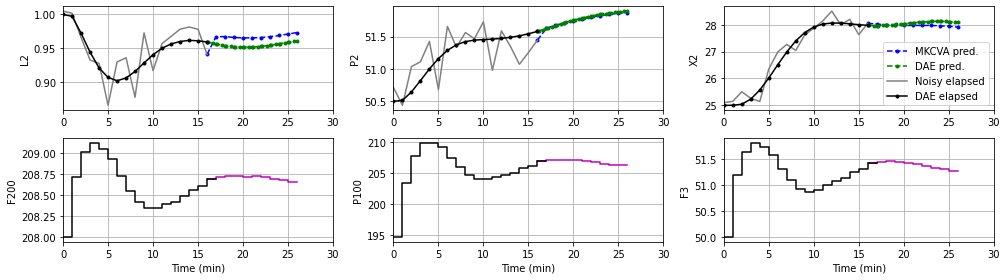

Horizon: 17 min to 27 min
IPOPT took 4.65 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


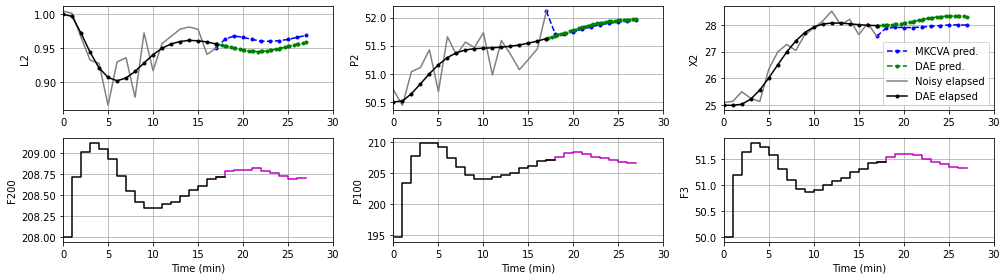

Horizon: 18 min to 28 min
IPOPT took 4.77 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


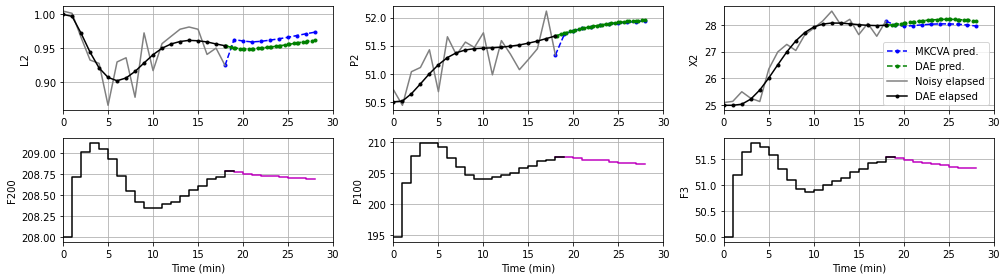

Horizon: 19 min to 29 min
IPOPT took 1.65 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


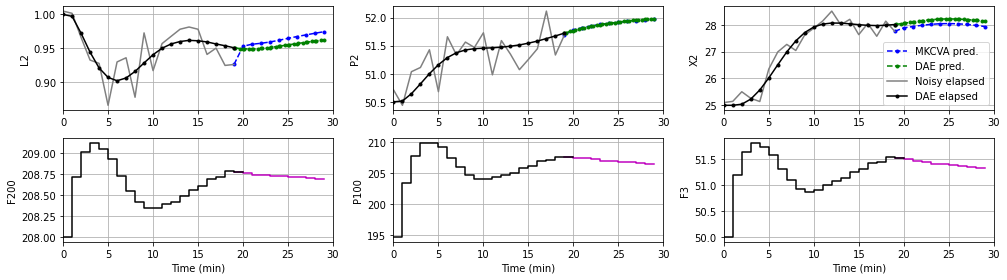

In [7]:
N_hor = 10                       # Prediction horizon
N_iter = 20                      # No. of MPC iterations
X2_sp = 28                       # Setpoint for X2
nvar = (N_hor-1)*len(sys.UI)     # No. of decision variables for IPOPT

np.random.seed(0)

# Pre-allocate arrays for saving results
u_save = np.zeros((N_iter+1, len(sys.UI)))
ipopt_save = np.zeros((N_iter, nvar))
dae_save = []
mdl_save = np.zeros((N_iter, (N_hor + 1)*len(sys.YI)))
y_mkcva_save = np.zeros((N_iter+1, len(sys.YI)))
y_pyomo_save = np.zeros((N_iter+1, len(sys.YI)))
y_noisy = np.zeros((N_iter+1, len(sys.YI)))

# Initialize the MKCVA model
u0 = np.array([208, 194.7, 50])
x0 = np.zeros((sys.n_states, 1))
y0 = np.array([1, 50.5, 25])

# Initialize the Pyomo DAE model
init_data = {'L2':1, 'P2':50.5, 'X2':25, 'F2':2,
             'F200': u0[0], 'P100': u0[1], 'F3': u0[2],
             'dL2dt':0, 'dP2dt':0, 'dX2dt':0}
u_names = ['F200', 'P100', 'F3']

# Save initial condition
u_save[0, :] = u0.ravel()
y_mkcva_save[0, :] = y0.ravel()
y_pyomo_save[0, :] = y0.ravel()

# Add noise to y0 (MKCVA only sees x0, u0, y0)
y0 = (y0 + (np.random.rand(3)-0.5)*np.array([0.1, 1, 1])).reshape(-1, 1)
y_noisy[0, :] = y0.ravel()
res = []

# ROLLING HORIZON MPC
for t in range(N_iter):
    
    # Solve control moves using IPOPT
    start = time()
    nlp = cyipopt.problem(
                n=nvar,
                m=0,
                problem_obj=NLP_MPC(x0, y0, u0, X2_sp),
                lb=np.zeros(nvar),
                ub=np.ones(nvar))

    nlp.addOption('tol', 1e-1)
    init_guess = 0.5 + np.zeros(nvar)
    if t >= 1:
        init_guess = np.hstack((res[3:], res[-3:]))
    
    res, info = nlp.solve(init_guess)
    ipopt_save[t, :] = res

    print(f'Horizon: {t} min to {t+N_hor} min')
    print(f"IPOPT took {(time() - start):.2f} sec.")
    print(info['status_msg'])

    # Implement the control moves on the MKCVA surrogate
    # Note: x, y already contains x0, y0
    
    u_res = (res.reshape(-1, 3)-0.5) * np.array([100, 100, 20]) + \
                                       np.array([208, 194.7, 50])   # nominal condition
    u_res = np.hstack((u0.reshape(-1, 1), np.transpose(u_res)))
    x, y = sim_mpc(sys, x0, y0, u_res)
    mdl_save[t, :] = y.ravel()

    # Implement the control moves on the Pyomo model
    F200data, P100data, F3data = u_res[0], u_res[1], u_res[2]

    evap_df, pyomo_res = solve_model(t, t+u_res.shape[1], F200data, P100data, F3data, N_hor, init_data)
    print(f"Pyomo Status: {pyomo_res.Solver.status}")

    # Replace the init_data with conditions at next sampling instant
    for k in init_data.keys():
        init_data[k] = evap_df[k].iloc[3]
        
    dae_save.append(evap_df.iloc[:, :3].to_numpy())
    
    # Get latest known y
    y_last = evap_df.iloc[3, :3].to_numpy()
    
    # Replace x0, y0, u0 with conditions at next sampling instant
    x0 = x[1, :].reshape(-1, 1)
    u0 = u_res[:, 1].reshape(-1, 1)
    
    #y0 = y[1, :].reshape(-1, 1)   # MKCVA does NOT have access to last known y from Pyomo
    #y0 = y_last.reshape(-1, 1)    # MKCVA does have access to last known y from Pyomo
    
    # MKCVA does have access to latest y but it's noisy
    y0 = (y_last + (np.random.rand(3)-0.5)*np.array([0.1, 1, 1])).reshape(-1, 1)
    
    # Save results
    u_save[t+1, :] = u0.ravel()
    y_mkcva_save[t+1, :] = y[1, :].ravel()
    y_pyomo_save[t+1, :] = y_last.ravel()
    y_noisy[t+1, :] = y0.ravel()
    
    # Plot current results
    plt.figure(figsize=(14, 4))
    
    for j in range(3):
        plt.subplot(2, 3, j+1)
        plt.plot(t + np.arange(0, len(y)), y[:, j], 'b.--', label='MKCVA pred.')
        plt.plot(evap_df.index, evap_df.iloc[:, j], 'g.--', label='DAE pred.')
        if t >= 1:
            plt.plot(np.arange(0, t+1), y_noisy[:t+1, j], c='0.5', label='Noisy elapsed')
            plt.plot(np.arange(0, t+1), y_pyomo_save[:t+1, j], 'k.-', label='DAE elapsed')
        plt.ylabel(evap_df.columns[j])
        plt.xlim([0, N_iter+N_hor])
        plt.grid()
        if j == 2:
            plt.legend(loc='lower right')
        
        plt.subplot(2, 3, j+4)
        plt.step(t + np.arange(0, u_res.shape[1]+1), 
                 np.hstack((u_res[j, :], u_res[j, -1])), # Repeat the last element
                 where='post', c='m')                    # Zero-order hold 'post' the change
        if t >= 1:
            plt.step(np.arange(0, t+2), np.hstack((u_save[:t+1, j], u_save[t, j])), 
                     where='post', c='k')
        plt.ylabel(u_names[j])
        plt.xlim([0, N_iter+N_hor])
        plt.xlabel('Time (min)')
        plt.grid()

    plt.tight_layout()
    plt.show()    

## Evaluate Tracking MPC Performance

In [8]:
# Calculate IAE
IAE = np.sum(np.abs(y_pyomo_save[:, 2] - X2_sp))
print(f"IAE: {IAE:.4f}")

# Save all results in a json file
all_data = {}
all_data['u_save'] = u_save.tolist()
all_data['ipopt_save'] = ipopt_save.tolist()
all_data['dae_save'] = np.stack(dae_save, axis=2).tolist()
all_data['mdl_save'] = mdl_save.tolist()
all_data['y_mkcva_save'] = y_mkcva_save.tolist()
all_data['y_pyomo_save'] = y_pyomo_save.tolist()
all_data['y_noisy_save'] = y_noisy.tolist()

with open('mkcva_cons_outputs.json', 'w') as f:
    json.dump(all_data, f)

IAE: 19.9374
